In [1]:
import numpy as np
import sys 
sys.path.insert(0, '..')
from rlss_practice.model import Environment, Agent, MAB_env
from rlss_practice.display import plot_result
from scipy.stats import bernoulli
from math import log

import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Interaction protocol
Highlight here the difference between what we can observe in practice (rewards) and what we can evaluate for scientific experiments (regrets)

In [2]:
def play(environment, agent, N, T):
    """
    Play N trajectories over a horizon T for the specified agent. 
    Return the agent's name (string) and the collected data in an nd-array.
    """
    
    rewards = np.zeros((N, T))
    regrets = np.zeros((N, T))
    
    for n in range(N):
        agent.reset()
        for t in range(T):
            action = agent.get_action() 
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            rewards[n,t] = reward
            # compute instantaneous regret
            means = environment.get_means()
            best_reward = np.max(means)
            regrets[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            
    return agent.name(), rewards, regrets


def experiment(environment, agents, N, T, mode="regret"):
    """
    Play N trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """
    
    all_data = {}
    
    for agent in agents:
        agent_id, rewards, regrets = play(environment, agent, N, T)
        
        if mode == "regret":
            all_data[agent_id] = regrets
        else:
            all_data[agent_id] = rewards
        
    return all_data

## Multi-Armed Bandit

In [3]:
K = 3  # number of arms

means = np.array([0.1, 0.3, 0.9])

T = 1000  # Horizon
N = 50  # Monte Carlo simulations

delta = 0.05 # could be set directly in the algorithms

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of percentile display
q = 10

### (Epsilon) Greedy

The idea is to give them a 3-arms bandit with Gaussian rewards and an incomplete implementation of epsilon-greedy that is just greedy/FTL. The exercise is to see the failure of FTL, complete the implementation of epsilon-greedy and try to tune the epsilon. Also visualize both reward and regret plots and learn to interpret them

In [4]:
class EpsilonGreedy(Agent):
  def __init__(self, K, eps=0.1):
    self.eps = eps # exploration probability
    self.K = K
    self.reset()
    
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)

    
  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)


  def get_action(self):
    #TO FILL:
    u = np.random.random()
    if u<self.eps:
        return np.random.choice(self.K)
    else:
    #END
    #only this part is given (greedy):
        chosen_arm_index = np.argmax(self.avg_rewards)
        return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1   
        

  #@staticmethod
  def name(self):
    return 'EGreedy('+str(self.eps)+')'

In [5]:
env = MAB_env(means)
greedy = EpsilonGreedy(K,  eps=0.)
epsilon_greedy = EpsilonGreedy(K,  eps=0.1)


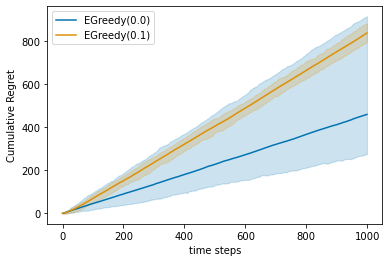

In [6]:
greedy_experiment = experiment(env, [greedy, epsilon_greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=10);

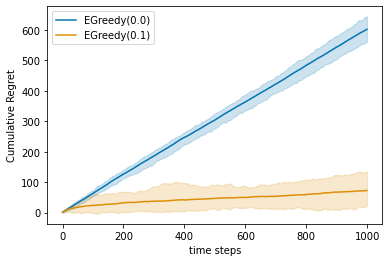

In [7]:
greedy_experiment = experiment(env, [greedy, epsilon_greedy], N=N, T=T, mode="regret")
plot_result(greedy_experiment, q=10);

### UCB

Idea: just implement the UCB score and compare with epsilon-greedy

In [8]:
class UCB(Agent):
  def __init__(self, K, delta=0.05):
    self.delta = delta #failure probability
    self.K = K
    self.reset()
    
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)

    
  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)


  def get_action(self):
    #TO FILL:
    with np.errstate(divide='ignore'):
        bonuses = np.sqrt(2 * np.log(1 / self.delta) / self.num_played)
    scores = self.avg_rewards + bonuses
    ##END
    
    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1   
        

  #@staticmethod
  def name(self):
    return 'UCB('+str(self.delta)+')'

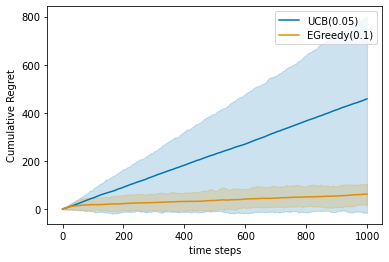

In [9]:
env = MAB_env(means)
epsilon_greedy = EpsilonGreedy(K,  eps=0.1)
ucb = UCB(K,  delta=0.05)
ucb_experiment = experiment(env, [ucb, epsilon_greedy], N=N, T=T)
plot_result(ucb_experiment, q=10);

## Thompson Sampling

Idea: briefly show how TS with Gaussian prior and likelihood is equivalent to adding Gaussian noise to avg rewards; implement the TS "scores" and compare with epsilon-greedy

In [10]:
class ThompsonSampling(Agent):
  def __init__(self, K, sigma=1.):
    self.sigma = sigma #prior std
    self.K = K
    self.reset()
    
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)
    self.stds = self.sigma * np.ones(self.K) #TO FILL

    
  def reset(self):
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.stds = self.sigma * np.ones(self.K) #TO FILL

  def get_action(self):
    #TO FILL:
    scores = np.random.normal(self.avg_rewards, self.stds)
    ##END
    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]
    
    self.stds[chosen_arm] = self.sigma / self.num_played[chosen_arm] #TO FILL
    
    self.t += 1   
        

  #@staticmethod
  def name(self):
    return 'TS('+str(self.sigma)+')'

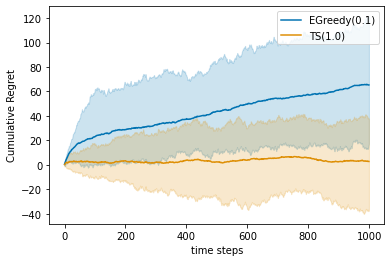

In [11]:
env = MAB_env(means)
epsilon_greedy = EpsilonGreedy(K,  eps=0.1)
ucb = UCB(K,  delta=0.05)
ts = ThompsonSampling(K, sigma=1.)
ts_experiment = experiment(env, [epsilon_greedy, ts], N=N, T=T)
plot_result(ts_experiment, q=10);

## Linear Bandits (all TODO)

In [12]:
def randomActionsGenerator(K,d, mean=None):
    return np.diag(np.full(d,1)) #vecs / norms[:,np.newaxis]

In [13]:
class IID_env(Environment):
    
    def __init__(self, theta, K):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.d = np.size(theta)
        self.theta = theta
        self.K = K

            
        
    def get_reward(self, action):
    
        """ sample reward given action 
        """

        return np.random.normal(self.theta[action])
            
    def get_means(self):
        return  self.theta

 # Environment Class

The environment class allows to create 3 types of linear bandit problems: 
* 'fixed' : normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'arbitrary': at each round, an 'arbitrary' set of actions is chosen and here we decided to simply create a pool of (d x K) vectors and let the environment choose K of them without replacement at each round;
* 'iid' : at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

In [ ]:
class EpsilonGreedy(Agent):
  def __init__(self, d, eps=0.1):
    self.eps = eps # exploration probability
    self.d = d
    self.reset()
    
    self.cumulative_reward = np.zeros(self.d)
    self.num_played = np.zeros(self.d)
    self.hat_theta = np.zeros(self.d)

    
  def reset(self):
    self.t = 0
    self.hat_theta = np.zeros(self.d)


  def get_action(self):
    
    u = np.random.random()
    if u<self.eps:
        return np.random.choice(self.d)
    else:
        chosen_arm_index = np.argmax(self.hat_theta)
        return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """

    self.cumulative_reward[chosen_arm] += reward # update
    self.num_played[chosen_arm] += 1
    self.hat_theta[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1   
        

  #@staticmethod
  def name(self):
    return 'EGreedy('+str(self.eps)+')'

In [ ]:
d = 3  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
# theta = randomActionsGenerator(1,d)
theta = np.array([0.1, 0.3, 0.9])

T = 1000  # Horizon
N = 50  # Monte Carlo simulations

delta = 0.05 # could be set directly in the algorithms

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of percentile display
q = 10

In [ ]:
iid_env = IID_env(theta, d) 
e_greedy = EpsilonGreedy(d,  eps=0.1)

In [ ]:
e_greedy_experiment = experiment(iid_env, [e_greedy], Nmc=N, T=T)
plot_regret(e_greedy_experiment, q=10)